In [1]:
from imports import *
pd.options.display.max_columns = 100

In [2]:
df = pd.read_csv("cleaned_data/cleaned_wvs_data.csv")

### Table of Contents
#### 1. Summary Table
#### 2. Histograms
#### 3. Violin Plots
#### 4. Scatterplots
#### 5. Heatmap

# 1. Summary Table

Find the summary table of the numeric features below. The sample includes 89 countries over 3 time periods. GDP per capita is in constant 2010 US dollars. The Democracy Index ranges from 0 (least democratic) to 10 (most democratic). The Human Development Index ranges from 0 (least developed) to 1 (most developed). Work ethic, trust, equality and religion are standardized indices ranging from 1-5. 

In [3]:
# Create numeric summary statistics
summary = pd.DataFrame()

numeric_vars = ['democracy_score', 'work_ethic', 'trust', 
               'equality', 'religion', 'gdp_per_capita', 'hdi']

for var in numeric_vars:
    stats = pd.Series({
        'Count': df[var].count().round(0),
        'Mean': df[var].mean().round(2),
        'Std Dev': df[var].std().round(2),
        'Min': df[var].min().round(2),
        '25%': df[var].quantile(0.25).round(2),
        'Median': df[var].median().round(2),
        '75%': df[var].quantile(0.75).round(2),
        'Max': df[var].max(),
        'Missing': df[var].isna().sum(),
        'Missing %': (df[var].isna().sum() / len(df[var])) * 100
    }).round(3)
    
    summary[var] = stats
    
# Print categorical summary
print("\nDataset Overview:")
print("-----------------")
print(f"Number of Columns: {df.shape[1]}")
print(f"Number of Countries: {len(df["country"].unique())}")
print(f"Number of Periods: 3")
print(f"Total Observations: {df.shape[0]}")

# Display the styled table
display(summary)


Dataset Overview:
-----------------
Number of Columns: 42
Number of Countries: 89
Number of Periods: 3
Total Observations: 267


,democracy_score,work_ethic,trust,equality,religion,gdp_per_capita,hdi
Count,267.00,267.000,267.000,267.000,267.000,267.000,267.000
Mean,5.87,1.680,2.410,2.160,3.210,16021.720,0.750
Std Dev,2.08,0.270,0.240,0.170,0.340,19686.670,0.140
Min,1.74,1.010,1.430,1.580,2.090,240.350,0.340
25%,3.92,1.510,2.290,2.040,3.010,2587.180,0.680
Median,6.03,1.680,2.440,2.180,3.210,6527.660,0.760
75%,7.60,1.830,2.560,2.270,3.440,22179.360,0.860
Max,9.66,2.712,2.931,2.726,4.203,85502.268,0.949
Missing,0.00,0.000,0.000,0.000,0.000,0.000,0.000
Missing %,0.00,0.000,0.000,0.000,0.000,0.000,0.000


# 2. Histograms

The below figure displays the histogram of each feature for each different wave of data. 
1) The democracy scores are, by far, the feature with the most variance. Indeed, whereas the six predictors tend to cluster within only a part of the distribution, the democracy scores occupy nearly the entire range between 1 and 10. 
2) The religion distribution appears to shift leftward over time, whereas the trust distribution appears to shift rightward. 
3) GDP is right-skewed, HDI is somewhat left-skewed, and democracy score is uniform. The scores for the moral values are approximately normally distributed. In addition, GDP is the only variable with significant outliers.

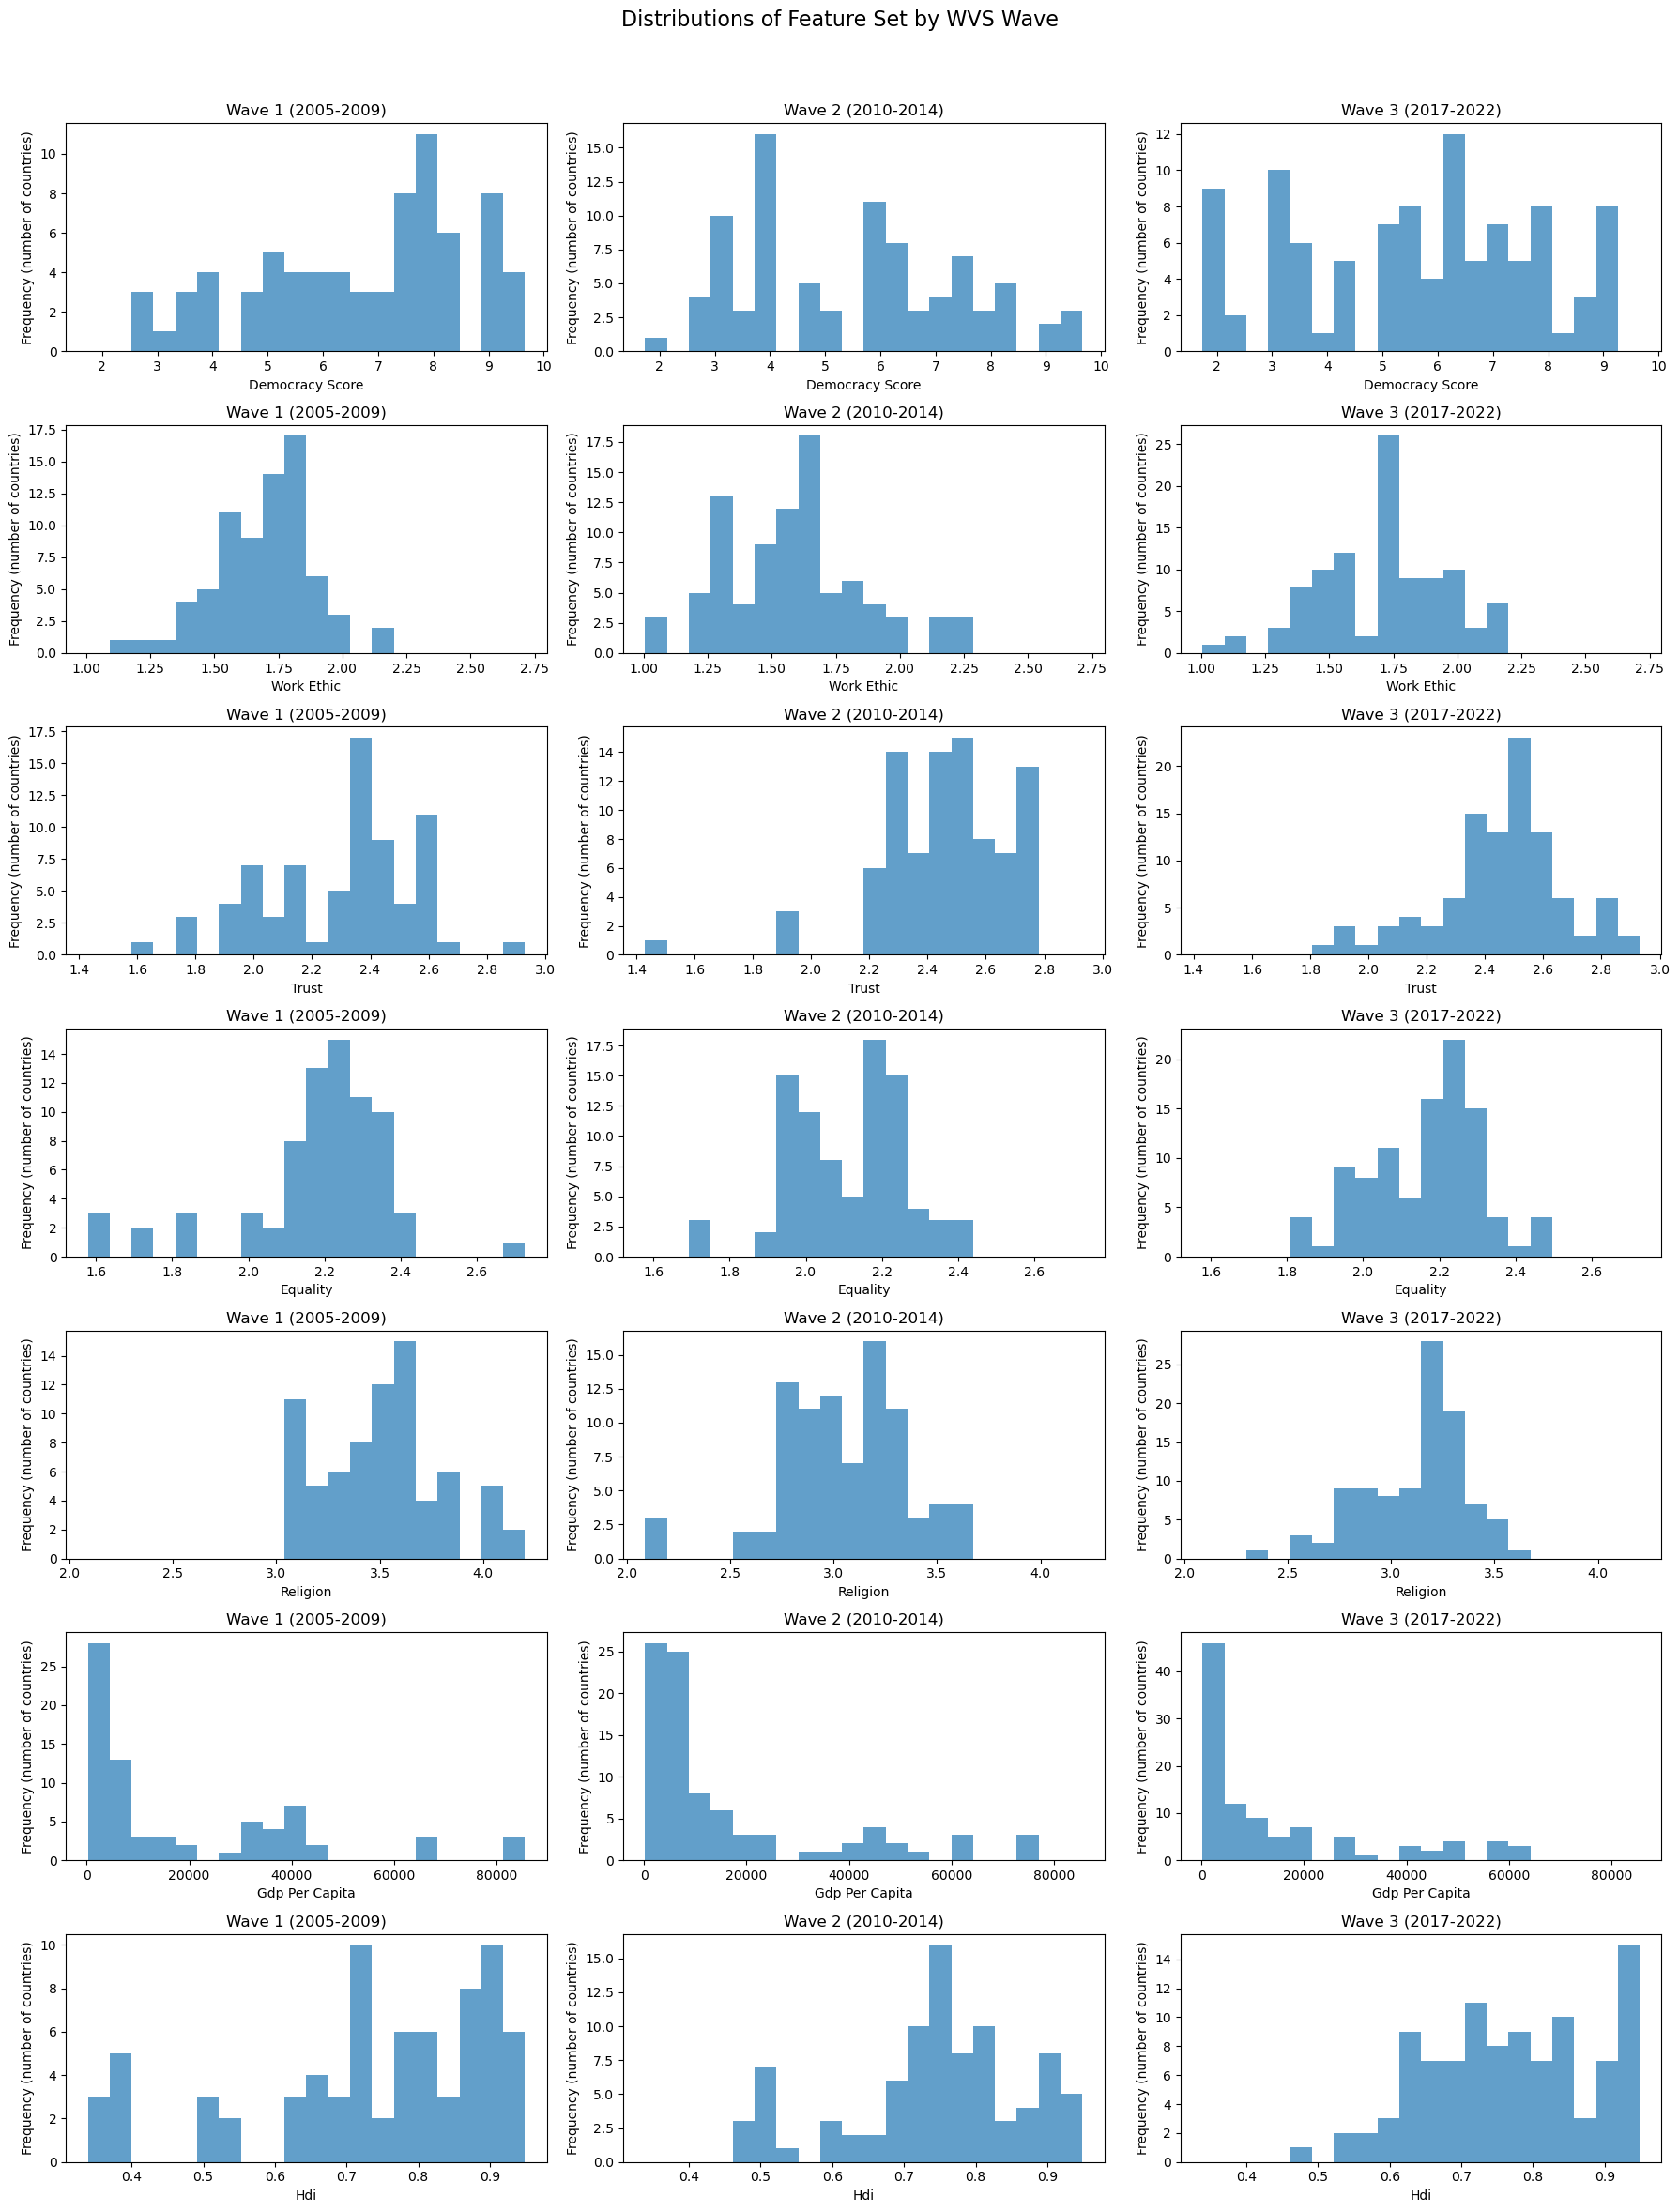

In [4]:
# create figure
fig, axes = plt.subplots(7, 3, figsize=(18, 24))
fig.suptitle('Distributions of Feature Set by WVS Wave', fontsize=16)

# I am add to waves so that they cover all of time from 1995.
# Assumption, associate data back one wave if is not in a wave. 
moral_values = ["democracy_score", "work_ethic", "trust", "equality", "religion", "gdp_per_capita", "hdi"]
waves = {1: [2005, 2009], 2: [2010, 2014], 3: [2017, 2022]}

# Create histograms for each combination
for i, value in enumerate(moral_values):
    # Get range for current moral value for consistent binning
    value_range = (df[value].min(), df[value].max())
    
    for j, (wave, years) in enumerate(waves.items()):
        # Filter data for current wave
        wave_data = df[(df['Year'] >= years[0]) & (df['Year'] <= years[1])]
        
        # Create histogram
        axes[i, j].hist(wave_data[value], bins=20, alpha=0.7, range=value_range)
        
        # Fix labeling
        value_name = value.replace('_', ' ').title()
        axes[i, j].set_title(f'Wave {wave} ({years[0]}-{years[1]})')
        axes[i, j].set_xlabel(f'{value_name}')
        axes[i, j].set_ylabel('Frequency (number of countries)')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('figures/histograms.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# 3. Violin Plots

The following violinplots show the distribution of each score --- trust, work ethic, equality, and religion --- when cut into income, human development index, and democracy index, quartiles. This plot yields several interesting conclusions:

1) Across all cuts, there appears to be a pretty uniform trend in mean score, either upward or downward. This suggests that the scores are quite correlated with income, human development, and democracy.

2) Most scores increase, on average, as income, HDI, and democracy increase. But trust seems to _decrease_! This is fascinating, and generates several new questions about the dataset. 

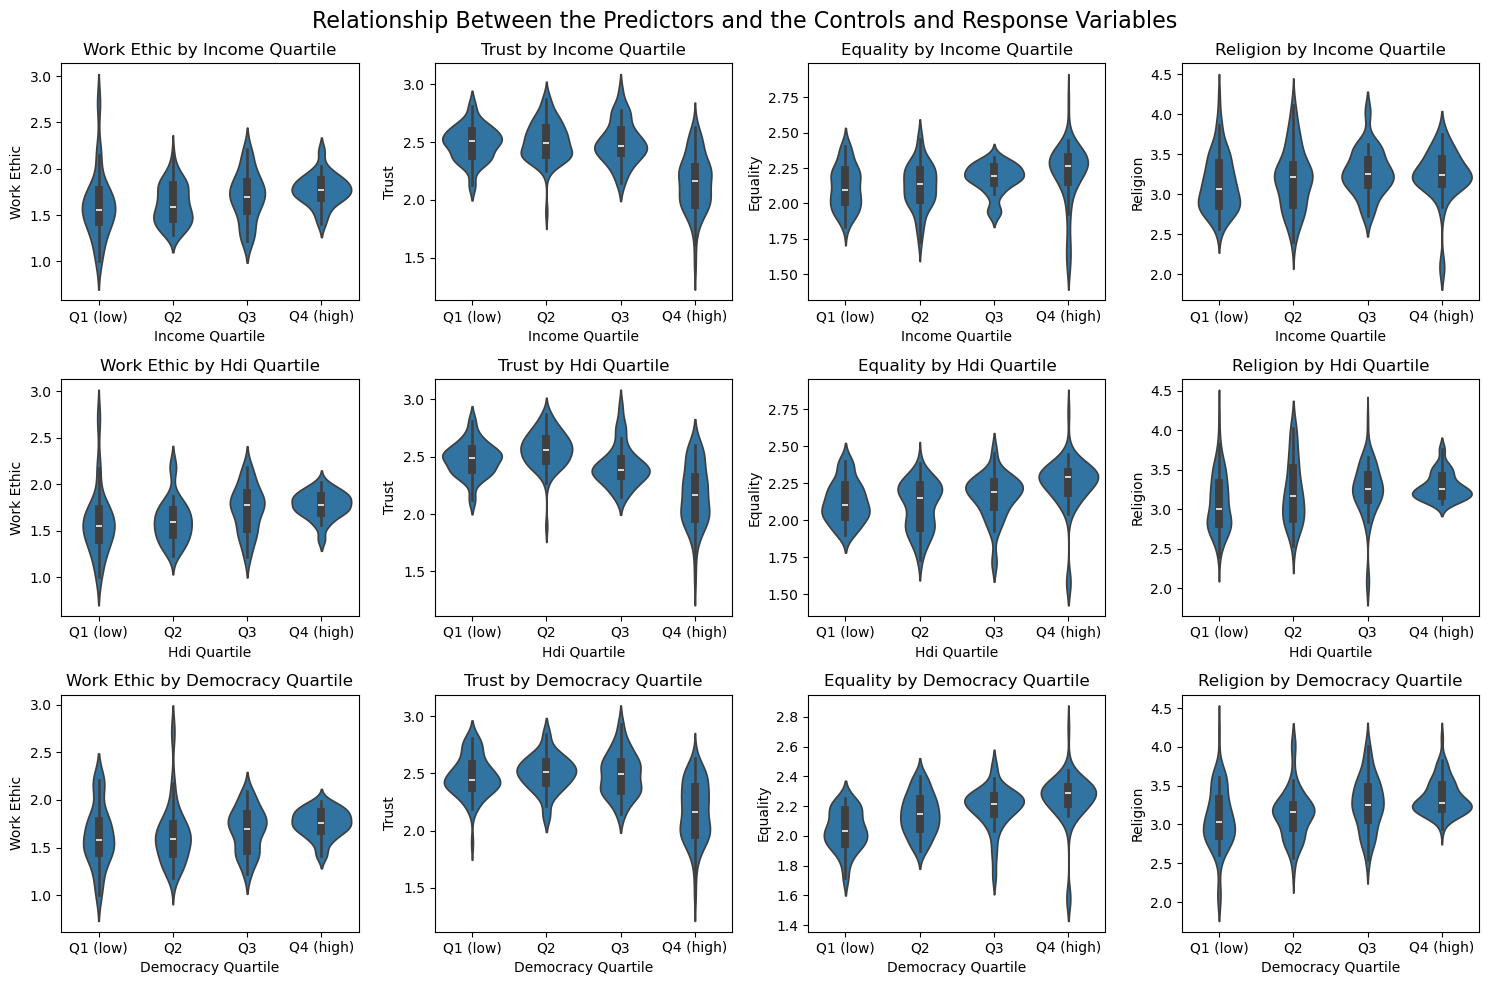

In [5]:
# create income quartiles
df['income_quartile'] = pd.qcut(df['gdp_per_capita'], q=4, labels=['Q1 (low)', 'Q2', 'Q3', 'Q4 (high)'])

# create HDI buckets
df['hdi_quartile'] = pd.qcut(df['hdi'], q=4, labels=['Q1 (low)', 'Q2', 'Q3', 'Q4 (high)'])

# create Democracy buckets
df['democracy_quartile'] = pd.qcut(df['democracy_score'], q=4, labels=['Q1 (low)', 'Q2', 'Q3', 'Q4 (high)'])

# create violinplots
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
fig.suptitle('Relationship Between the Predictors and the Controls and Response Variables', fontsize=16)

cuts = ["income_quartile", "hdi_quartile", "democracy_quartile"]
scores = ["work_ethic", "trust", "equality", "religion"]

for i, cut in enumerate(cuts):
    for j, predictor in enumerate(scores):
        sns.violinplot(data=df, x=cut, y=predictor, ax=axes[i, j])
        
        # fix labelling
        x_name = cut.replace('_', ' ').title() 
        y_name = predictor.replace('_', ' ').title()
        axes[i, j].set_title(f"{y_name} by {x_name}")
        axes[i, j].set_xlabel(f"{x_name}")
        axes[i, j].set_ylabel(f"{y_name}")

plt.tight_layout()
plt.savefig('figures/violinplots.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# 4. Scatterplots

Below are the scatterplots of the predictor variables on the dependent variable.
1) The relationships between GDP and Democracy and HDI and Democracy are not linear, they look logarithmic. GDP and HDI also seem to have the strongest relationship with democracy.
2) Most relationships are positive, except trust, which is negative.

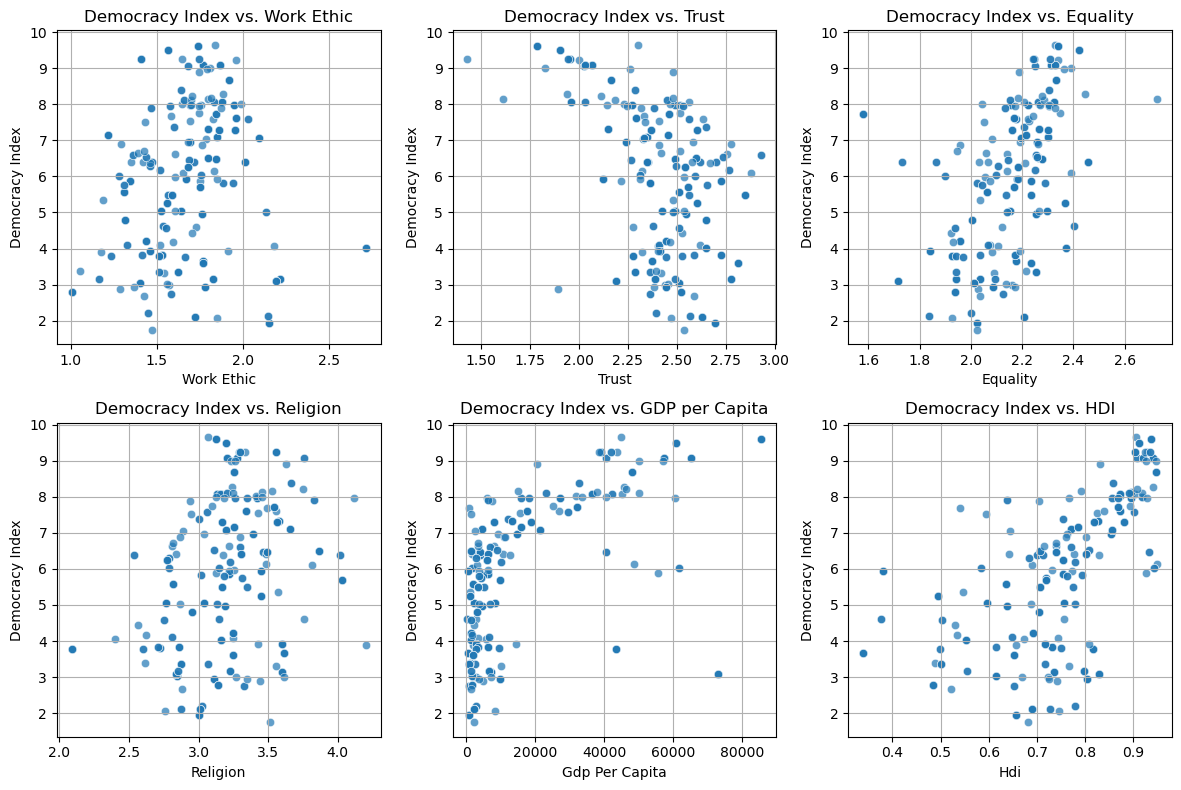

In [6]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
ax = ax.ravel() 

x_vars = ['work_ethic', 'trust', 'equality', 'religion', 'gdp_per_capita', 'hdi']
titles = ['Democracy Index vs. Work Ethic', 
          'Democracy Index vs. Trust', 
          'Democracy Index vs. Equality', 
          'Democracy Index vs. Religion', 
          'Democracy Index vs. GDP per Capita', 
          'Democracy Index vs. HDI']

for i, (x_var, title) in enumerate(zip(x_vars, titles)):
    sns.scatterplot(x=x_var, y='democracy_score', data=df, alpha=0.7, ax=ax[i])
    ax[i].set_title(title)
    ax[i].set_xlabel(x_var.replace('_', ' ').title()) 
    ax[i].set_ylabel('Democracy Index')
    ax[i].grid()

plt.tight_layout()
plt.savefig('figures/scatterplots.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# 5. Heatmap

Here is a heatmap showing the correlation amongst all the features. The highest correlations are among democracy, hdi, and gdp per capita. Trust has a negative correlation with every other predictor. All other correlations are postive.

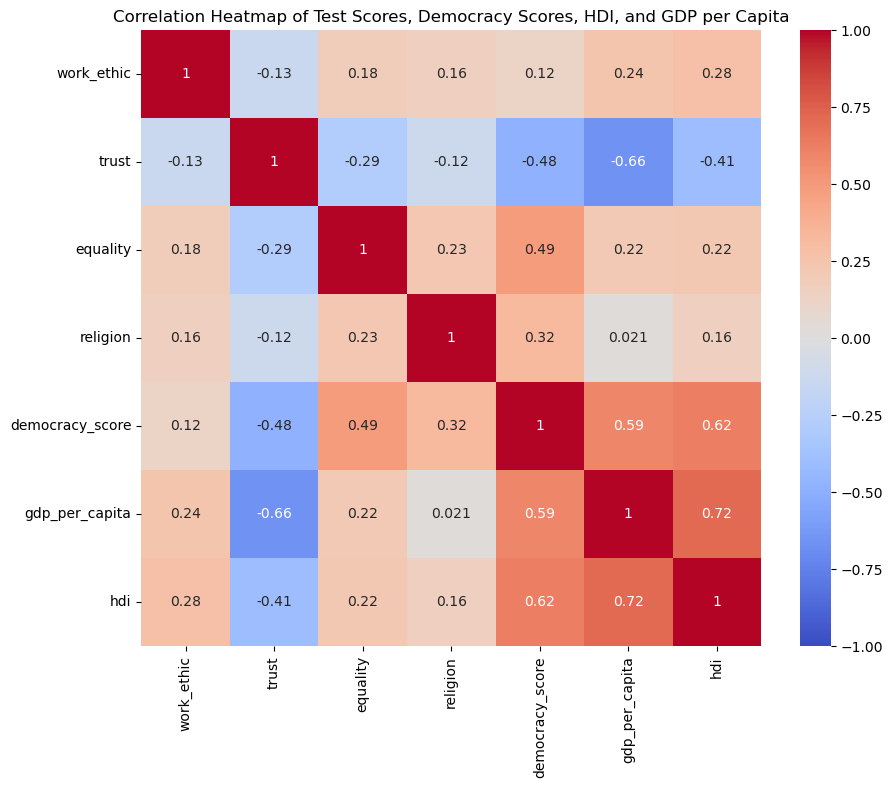

In [7]:
# Select the relevant columns for correlation
correlation_data = df[['work_ethic', 'trust', 'equality', 'religion', 'democracy_score', 'gdp_per_capita', 'hdi']]

# Calculate the correlation matrix
correlation_matrix = correlation_data.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Test Scores, Democracy Scores, HDI, and GDP per Capita')
plt.savefig('figures/corr_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()